In [5]:
# ============================================================
# CMSE 492 – Final Project
# Diabetes Risk Prediction from Health Indicators
# Final modeling and analysis notebook
# ============================================================

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
)

# Plotting style and reproducibility
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 120

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---------- YOUR ABSOLUTE PATHS ----------
DATA_PATH = "/Users/nicksleeper/documents/FS25 CMSE-492/cmse492_project/data/raw/diabetes_dataset.csv"
FIG_PATH  = "/Users/nicksleeper/documents/FS25 CMSE-492/cmse492_project/figures/"
REPORT_PATH = "/Users/nicksleeper/documents/FS25 CMSE-492/cmse492_project/reports/"

os.makedirs(FIG_PATH, exist_ok=True)
os.makedirs(REPORT_PATH, exist_ok=True)

In [6]:
# ============================================================
# Load dataset and inspect structure
# ============================================================

TARGET_COL = "diagnosed_diabetes"
DROP_COLS = ["diabetes_stage", "diabetes_risk_score"]  # leakage-type columns

# Load
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found in columns:\n{df.columns.tolist()}")

print("\nTarget distribution (counts):")
print(df[TARGET_COL].value_counts())
print("\nTarget distribution (proportions):")
print(df[TARGET_COL].value_counts(normalize=True).round(3))

df.head()

Dataset shape: (100000, 31)

Columns:
['age', 'gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'hba1c', 'diabetes_risk_score', 'diabetes_stage', 'diagnosed_diabetes']

Target distribution (counts):
diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64

Target distribution (proportions):
diagnosed_diabetes
1    0.6
0    0.4
Name: proportion, dtype: float64


,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


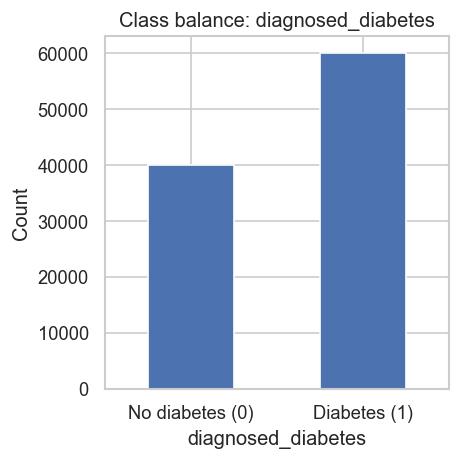

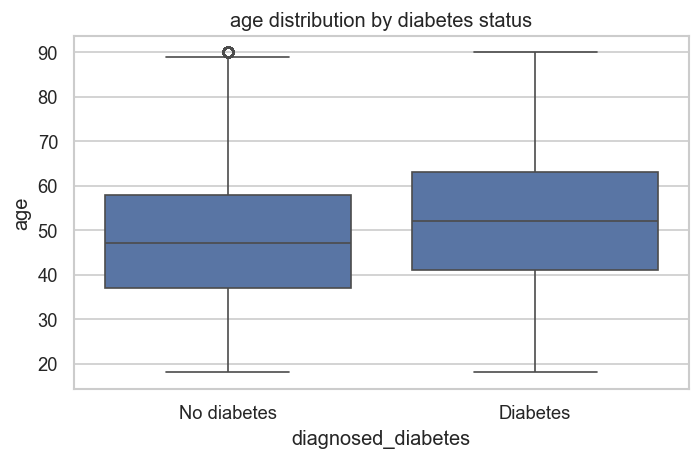

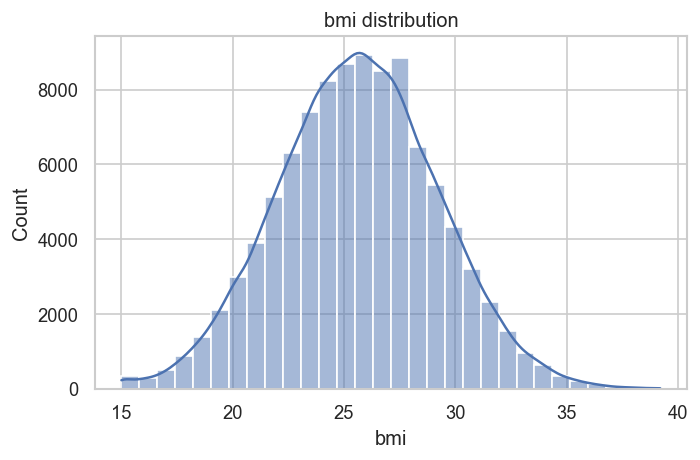

In [7]:
# ============================================================
# EDA – Class balance and simple univariate distributions
# ============================================================

# Class balance
plt.figure(figsize=(4, 4))
df[TARGET_COL].value_counts().sort_index().plot(kind="bar")
plt.xticks([0, 1], ["No diabetes (0)", "Diabetes (1)"], rotation=0)
plt.ylabel("Count")
plt.title("Class balance: diagnosed_diabetes")
plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, "class_balance.png"), dpi=300)
plt.show()

# Age distribution by diabetes status (try to find an age column)
age_col = None
for c in df.columns:
    if "age" in c.lower():
        age_col = c
        break

if age_col is not None:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x=TARGET_COL, y=age_col)
    plt.xticks([0, 1], ["No diabetes", "Diabetes"], rotation=0)
    plt.title(f"{age_col} distribution by diabetes status")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_PATH, "age_by_diabetes.png"), dpi=300)
    plt.show()
else:
    print("No age-like column found for age_by_diabetes plot.")

# BMI distribution (try to find BMI column)
bmi_col = None
for c in df.columns:
    if "bmi" in c.lower():
        bmi_col = c
        break

if bmi_col is not None:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[bmi_col], bins=30, kde=True)
    plt.title(f"{bmi_col} distribution")
    plt.xlabel(bmi_col)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_PATH, "bmi_distribution.png"), dpi=300)
    plt.show()
else:
    print("No BMI-like column found for bmi_distribution plot.")

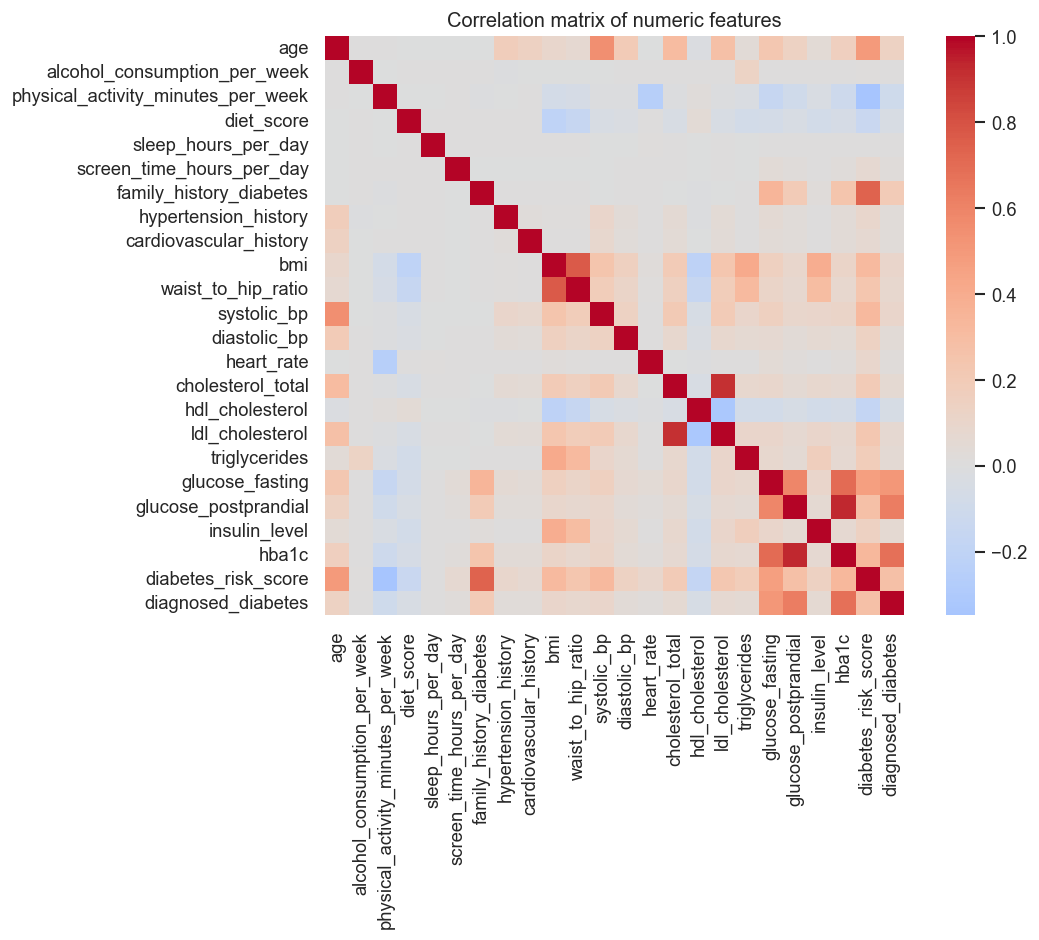

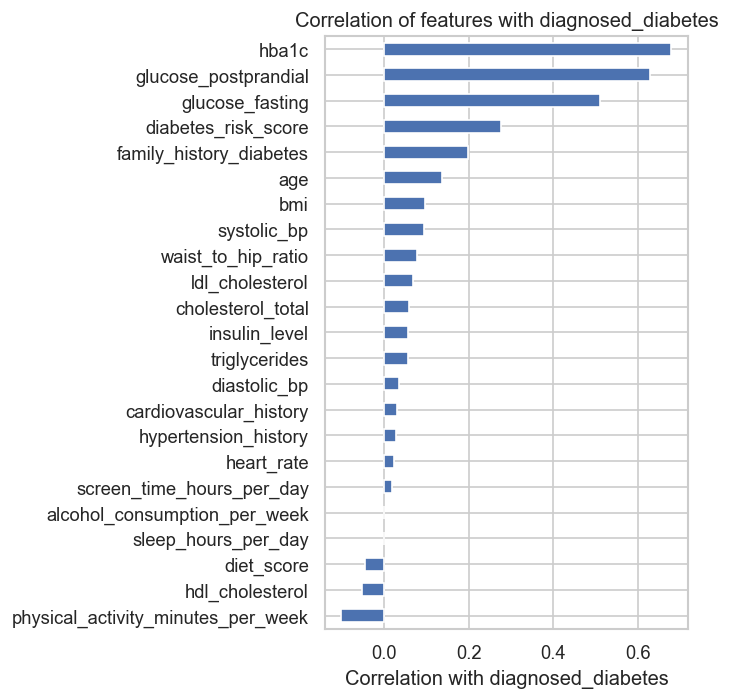

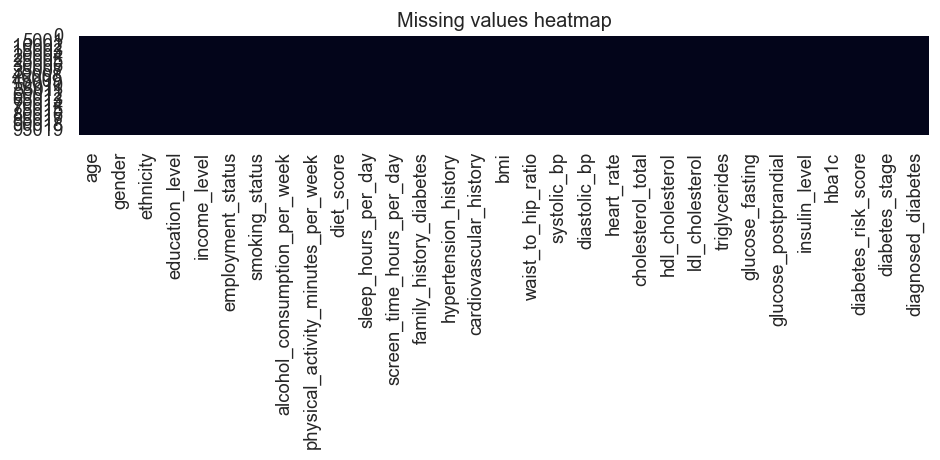

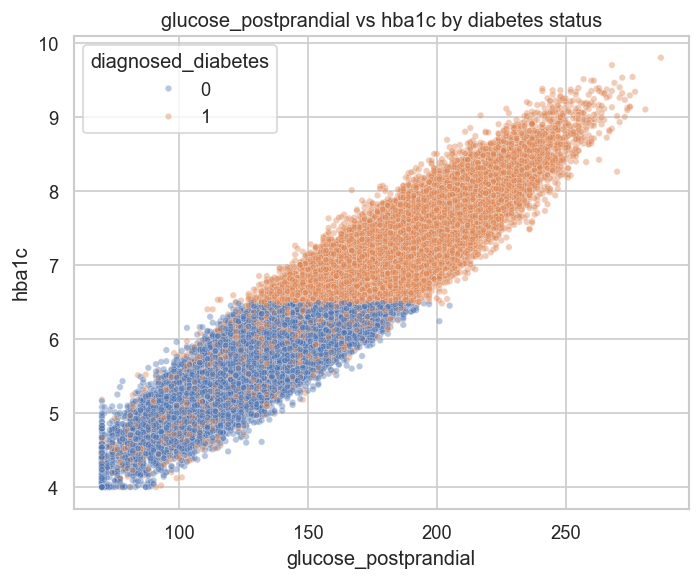

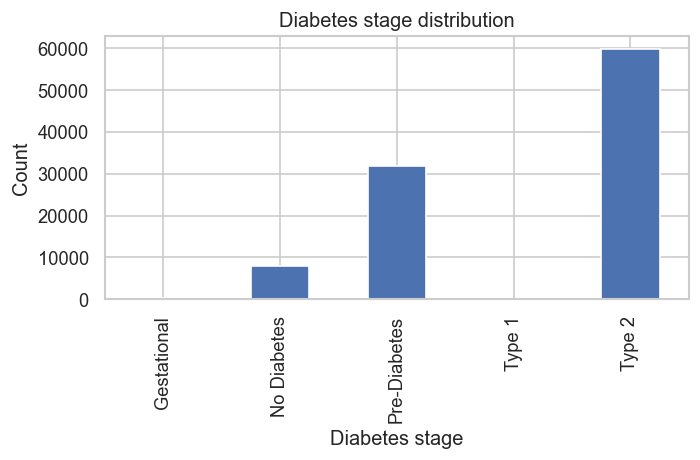

In [8]:
# ============================================================
# EDA – Correlation, missingness, glucose/HbA1c, diabetes stage
# ============================================================

# Numeric-only correlation matrix
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True)
plt.title("Correlation matrix of numeric features")
plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, "correlation_matrix.png"), dpi=300)
plt.show()

# Correlation with target
if TARGET_COL in numeric_df.columns:
    target_corr = corr[TARGET_COL].drop(TARGET_COL).sort_values(ascending=False)
    plt.figure(figsize=(6, 6))
    target_corr.plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.xlabel("Correlation with diagnosed_diabetes")
    plt.title("Correlation of features with diagnosed_diabetes")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_PATH, "correlation_with_target.png"), dpi=300)
    plt.show()
else:
    print("Target not numeric; skipping correlation_with_target.")

# Missing values heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing values heatmap")
plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, "missing_values_heatmap.png"), dpi=300)
plt.show()

# Glucose vs HbA1c scatter (if columns exist)
glucose_col = None
hba1c_col = None
for c in df.columns:
    if "glucose" in c.lower():
        glucose_col = c
    if "hba1c" in c.lower():
        hba1c_col = c

if glucose_col is not None and hba1c_col is not None:
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=df,
        x=glucose_col,
        y=hba1c_col,
        hue=TARGET_COL,
        alpha=0.4,
        s=15,
    )
    plt.title(f"{glucose_col} vs {hba1c_col} by diabetes status")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_PATH, "glucose_hba1c_scatter.png"), dpi=300)
    plt.show()
else:
    print("Glucose and/or HbA1c column not found; skipping glucose_hba1c_scatter plot.")

# Diabetes stage distribution (if column exists)
if "diabetes_stage" in df.columns:
    plt.figure(figsize=(6, 4))
    df["diabetes_stage"].value_counts().sort_index().plot(kind="bar")
    plt.xlabel("Diabetes stage")
    plt.ylabel("Count")
    plt.title("Diabetes stage distribution")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_PATH, "diabetes_stage_distribution.png"), dpi=300)
    plt.show()
else:
    print("No 'diabetes_stage' column found; skipping diabetes_stage_distribution plot.")

In [9]:
# ============================================================
# Train / validation / test split (70 / 15 / 15 stratified)
# ============================================================

# Drop target and leakage columns for features
X = df.drop(columns=[TARGET_COL] + DROP_COLS, errors="ignore")
y = df[TARGET_COL]

print("Feature matrix shape:", X.shape)

# First split: train vs temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,
    random_state=RANDOM_STATE,
)

# Second split: val vs test (each 15% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=RANDOM_STATE,
)

print(f"Train size: {X_train.shape[0]} ({X_train.shape[0] / df.shape[0]:.1%})")
print(f"Val size:   {X_val.shape[0]} ({X_val.shape[0] / df.shape[0]:.1%})")
print(f"Test size:  {X_test.shape[0]} ({X_test.shape[0] / df.shape[0]:.1%})")

Feature matrix shape: (100000, 28)
Train size: 70000 (70.0%)
Val size:   15000 (15.0%)
Test size:  15000 (15.0%)


In [13]:
# ============================================================
# Preprocessing (StandardScaler + OneHotEncoder) and models
# ============================================================

# Split feature names by type
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

transformers = []
if len(numeric_features) > 0:
    transformers.append(("num", StandardScaler(), numeric_features))
if len(categorical_features) > 0:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
)

# Base estimators
log_reg = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    class_weight=None,
    random_state=RANDOM_STATE,
)

rf = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

gb = GradientBoostingClassifier(
    random_state=RANDOM_STATE,
)

# Pipelines
pipe_log_reg = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", log_reg),
    ]
)

pipe_rf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", rf),
    ]
)

pipe_gb = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", gb),
    ]
)

# Parameter grids
param_grid_log_reg = {
    "model__C": [0.1, 1.0, 10.0],
    "model__penalty": ["l2"],
}

param_grid_rf = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [8, 12, None],
    "model__min_samples_split": [2, 5],
}

param_grid_gb = {
    "model__n_estimators": [200, 400],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [2, 3],
}

Numeric features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'hba1c']
Categorical features: ['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status']


In [14]:
# ============================================================
# Grid search (5-fold CV) for each model, optimizing F1
# ============================================================

def run_grid_search(pipe, param_grid, X_train, y_train, model_name):
    print(f"\n========== Grid Search: {model_name} ==========\n")
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="f1",    # primary metric
        cv=5,
        n_jobs=-1,
        verbose=1,
    )
    grid.fit(X_train, y_train)
    print(f"Best params for {model_name}: {grid.best_params_}")
    print(f"Best CV F1 for {model_name}: {grid.best_score_:.3f}")
    return grid.best_estimator_

best_log_reg = run_grid_search(pipe_log_reg, param_grid_log_reg, X_train, y_train, "Logistic Regression")
best_rf      = run_grid_search(pipe_rf,      param_grid_rf,      X_train, y_train, "Random Forest")
best_gb      = run_grid_search(pipe_gb,      param_grid_gb,      X_train, y_train, "Gradient Boosting")


========== Grid Search: Logistic Regression ==========

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params for Logistic Regression: {'model__C': 10.0, 'model__penalty': 'l2'}
Best CV F1 for Logistic Regression: 0.884

========== Grid Search: Random Forest ==========

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/miniconda3/envs/cmse492/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params for Random Forest: {'model__max_depth': 12, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV F1 for Random Forest: 0.930

========== Grid Search: Gradient Boosting ==========

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params for Gradient Boosting: {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 200}
Best CV F1 for Gradient Boosting: 0.930



Training and evaluating Logistic Regression

Validation metrics for Logistic Regression:
  Accuracy:  0.861
  Precision: 0.876
  Recall:    0.894
  F1 score:  0.885
  ROC AUC:   0.935

Test metrics for Logistic Regression:
  Accuracy:  0.860
  Precision: 0.875
  Recall:    0.895
  F1 score:  0.885
  ROC AUC:   0.933

Confusion matrix (test):
[[4852 1149]
 [ 949 8050]]

Classification report (test):
              precision    recall  f1-score   support

           0      0.836     0.809     0.822      6001
           1      0.875     0.895     0.885      8999

    accuracy                          0.860     15000
   macro avg      0.856     0.852     0.853     15000
weighted avg      0.860     0.860     0.860     15000



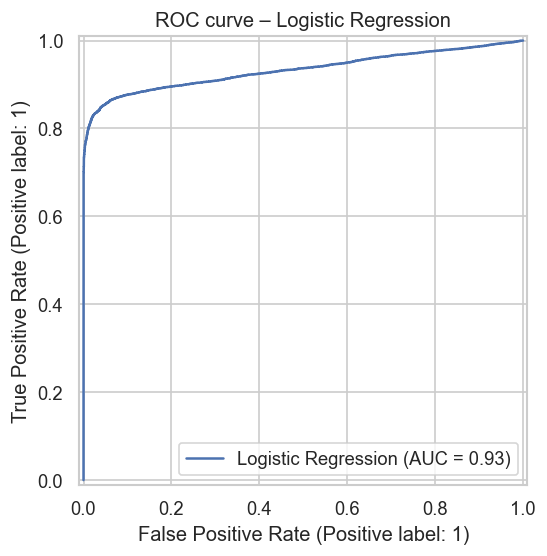


Training and evaluating Random Forest

Validation metrics for Random Forest:
  Accuracy:  0.920
  Precision: 0.999
  Recall:    0.867
  F1 score:  0.928
  ROC AUC:   0.943

Test metrics for Random Forest:
  Accuracy:  0.921
  Precision: 0.999
  Recall:    0.869
  F1 score:  0.929
  ROC AUC:   0.943

Confusion matrix (test):
[[5995    6]
 [1183 7816]]

Classification report (test):
              precision    recall  f1-score   support

           0      0.835     0.999     0.910      6001
           1      0.999     0.869     0.929      8999

    accuracy                          0.921     15000
   macro avg      0.917     0.934     0.920     15000
weighted avg      0.934     0.921     0.921     15000



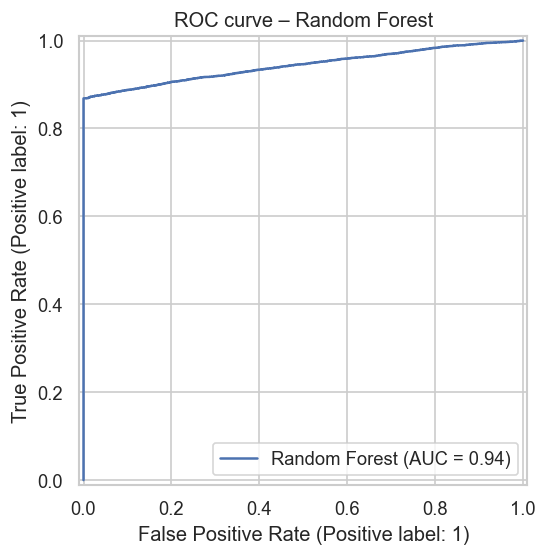


Training and evaluating Gradient Boosting

Validation metrics for Gradient Boosting:
  Accuracy:  0.920
  Precision: 1.000
  Recall:    0.867
  F1 score:  0.929
  ROC AUC:   0.945

Test metrics for Gradient Boosting:
  Accuracy:  0.921
  Precision: 1.000
  Recall:    0.869
  F1 score:  0.930
  ROC AUC:   0.945

Confusion matrix (test):
[[6001    0]
 [1183 7816]]

Classification report (test):
              precision    recall  f1-score   support

           0      0.835     1.000     0.910      6001
           1      1.000     0.869     0.930      8999

    accuracy                          0.921     15000
   macro avg      0.918     0.934     0.920     15000
weighted avg      0.934     0.921     0.922     15000



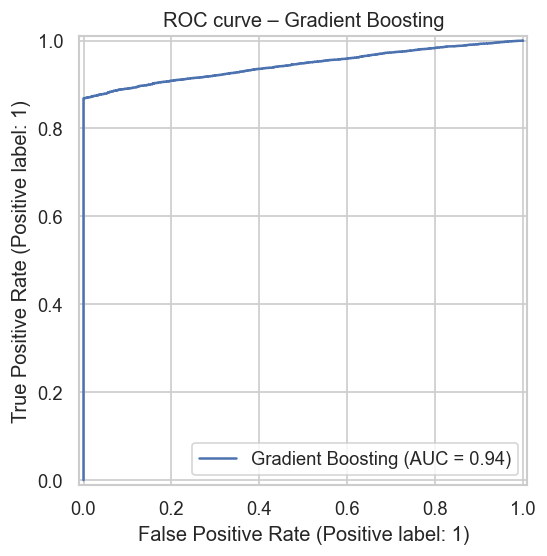


===== Summary of model performance (test set) =====

                 model  test_accuracy  test_precision  test_recall   test_f1  \
0  Logistic Regression       0.860133        0.875095     0.894544  0.884713   
1        Random Forest       0.920733        0.999233     0.868541  0.929315   
2    Gradient Boosting       0.921133        1.000000     0.868541  0.929646   

   test_roc_auc  
0      0.932951  
1      0.943217  
2      0.944707  


,model,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,Logistic Regression,0.860800,0.876389,0.894111,0.885161,0.934587,0.860133,0.875095,0.894544,0.884713,0.932951
1,Random Forest,0.919800,0.999488,0.866778,0.928414,0.943333,0.920733,0.999233,0.868541,0.929315,0.943217
2,Gradient Boosting,0.920067,1.000000,0.866778,0.928635,0.944973,0.921133,1.000000,0.868541,0.929646,0.944707


In [15]:
# ============================================================
# 8. Evaluation helper and tuned model evaluation
# ============================================================

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, name="Model"):
    print(f"\n==============================")
    print(f"Training and evaluating {name}")
    print(f"==============================\n")

    # Fit on train only
    model.fit(X_train, y_train)

    # Validation predictions
    y_val_pred = model.predict(X_val)
    if hasattr(model, "predict_proba"):
        y_val_proba = model.predict_proba(X_val)[:, 1]
    else:
        # fallback for models without predict_proba (not the case here, but safe)
        y_val_proba = model.decision_function(X_val)

    # Test predictions
    y_test_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_test_proba = model.decision_function(X_test)

    # Metrics on validation
    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred)
    val_rec = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_proba)

    print(f"Validation metrics for {name}:")
    print(f"  Accuracy:  {val_acc:.3f}")
    print(f"  Precision: {val_prec:.3f}")
    print(f"  Recall:    {val_rec:.3f}")
    print(f"  F1 score:  {val_f1:.3f}")
    print(f"  ROC AUC:   {val_auc:.3f}")

    # Metrics on test
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred)
    test_rec = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)

    print(f"\nTest metrics for {name}:")
    print(f"  Accuracy:  {test_acc:.3f}")
    print(f"  Precision: {test_prec:.3f}")
    print(f"  Recall:    {test_rec:.3f}")
    print(f"  F1 score:  {test_f1:.3f}")
    print(f"  ROC AUC:   {test_auc:.3f}")

    print("\nConfusion matrix (test):")
    print(confusion_matrix(y_test, y_test_pred))
    print("\nClassification report (test):")
    print(classification_report(y_test, y_test_pred, digits=3))

    # ROC curve (test)
    RocCurveDisplay.from_predictions(
        y_test,
        y_test_proba,
        name=name,
    )
    plt.title(f"ROC curve – {name}")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_PATH, f"roc_{name.replace(' ', '_').lower()}.png"), dpi=300)
    plt.show()

    metrics_dict = {
        "model": name,
        "val_accuracy": val_acc,
        "val_precision": val_prec,
        "val_recall": val_rec,
        "val_f1": val_f1,
        "val_roc_auc": val_auc,
        "test_accuracy": test_acc,
        "test_precision": test_prec,
        "test_recall": test_rec,
        "test_f1": test_f1,
        "test_roc_auc": test_auc,
    }

    return metrics_dict


results = []

results.append(
    evaluate_model(best_log_reg, X_train, y_train, X_val, y_val, X_test, y_test, name="Logistic Regression")
)
results.append(
    evaluate_model(best_rf, X_train, y_train, X_val, y_val, X_test, y_test, name="Random Forest")
)
results.append(
    evaluate_model(best_gb, X_train, y_train, X_val, y_val, X_test, y_test, name="Gradient Boosting")
)

results_df = pd.DataFrame(results)
print("\n===== Summary of model performance (test set) =====\n")
print(results_df[["model", "test_accuracy", "test_precision", "test_recall", "test_f1", "test_roc_auc"]])

# Save performance summary for LaTeX tables
results_df.to_csv(os.path.join(REPORT_PATH, "model_performance_summary.csv"), index=False)

results_df


Top 20 Logistic Regression coefficients (by absolute value):
num__hba1c                                 2.766093
num__glucose_fasting                       0.221141
cat__gender_Other                          0.196642
num__family_history_diabetes               0.165091
cat__smoking_status_Former                 0.132271
cat__employment_status_Unemployed          0.128681
cat__education_level_No formal             0.127110
cat__smoking_status_Current                0.124818
cat__income_level_High                     0.118618
cat__ethnicity_Other                       0.117398
cat__smoking_status_Never                  0.115929
num__age                                   0.111602
cat__employment_status_Employed            0.101210
cat__education_level_Graduate              0.100024
cat__education_level_Highschool            0.095591
cat__gender_Female                         0.095126
num__physical_activity_minutes_per_week   -0.092979
cat__ethnicity_Hispanic                    0.082119
ca

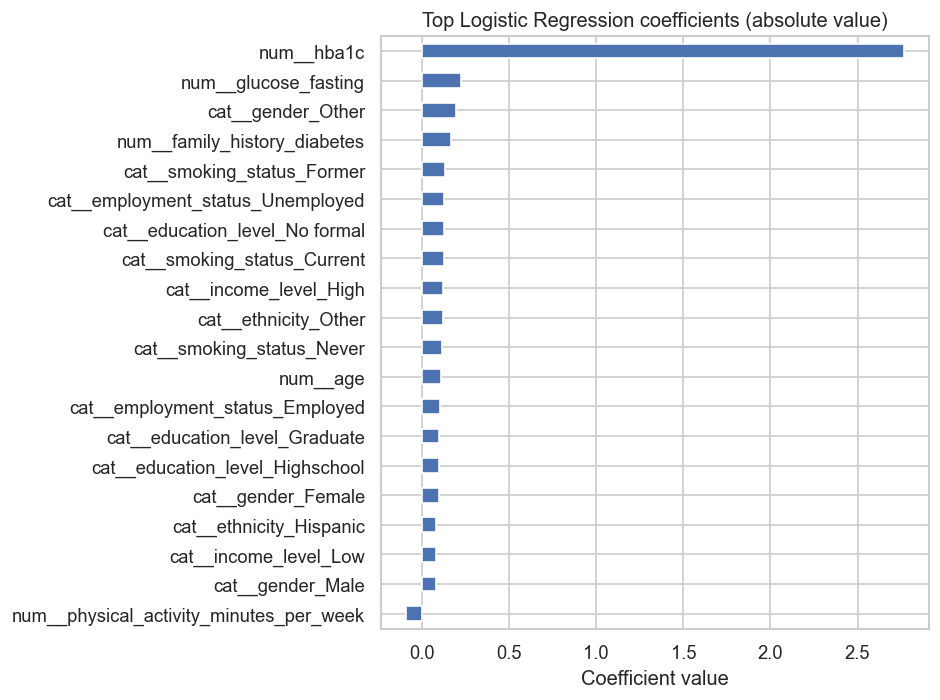


Top 20 Random Forest feature importances:
num__hba1c                                 0.542918
num__glucose_postprandial                  0.235567
num__glucose_fasting                       0.122960
num__family_history_diabetes               0.015259
num__age                                   0.009871
num__physical_activity_minutes_per_week    0.007258
num__bmi                                   0.005825
num__systolic_bp                           0.005247
num__cholesterol_total                     0.004326
num__insulin_level                         0.004309
num__triglycerides                         0.004305
num__hdl_cholesterol                       0.004214
num__ldl_cholesterol                       0.004125
num__diet_score                            0.003985
num__screen_time_hours_per_day             0.003838
num__waist_to_hip_ratio                    0.003608
num__heart_rate                            0.003594
num__sleep_hours_per_day                   0.003550
num__diastolic_bp    

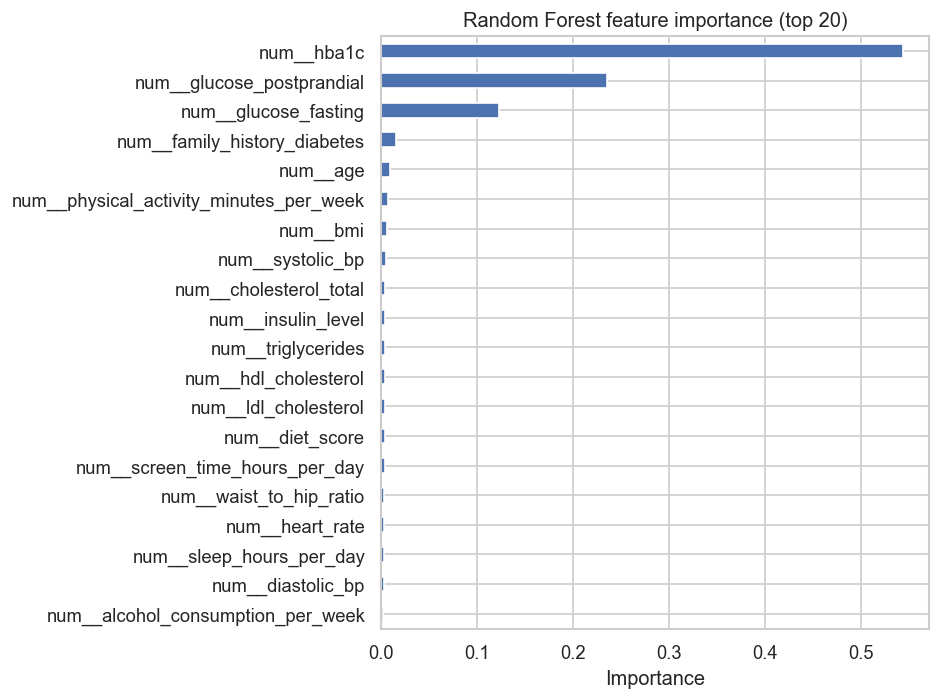


Top 20 Gradient Boosting feature importances:
num__hba1c                                 0.954620
num__glucose_fasting                       0.038321
num__family_history_diabetes               0.002811
num__age                                   0.002213
num__physical_activity_minutes_per_week    0.000836
num__bmi                                   0.000464
num__hdl_cholesterol                       0.000163
num__glucose_postprandial                  0.000156
num__systolic_bp                           0.000100
num__diastolic_bp                          0.000053
num__diet_score                            0.000045
num__ldl_cholesterol                       0.000044
num__cholesterol_total                     0.000044
num__triglycerides                         0.000042
num__insulin_level                         0.000032
num__waist_to_hip_ratio                    0.000029
num__sleep_hours_per_day                   0.000012
num__screen_time_hours_per_day             0.000007
cat__income_level

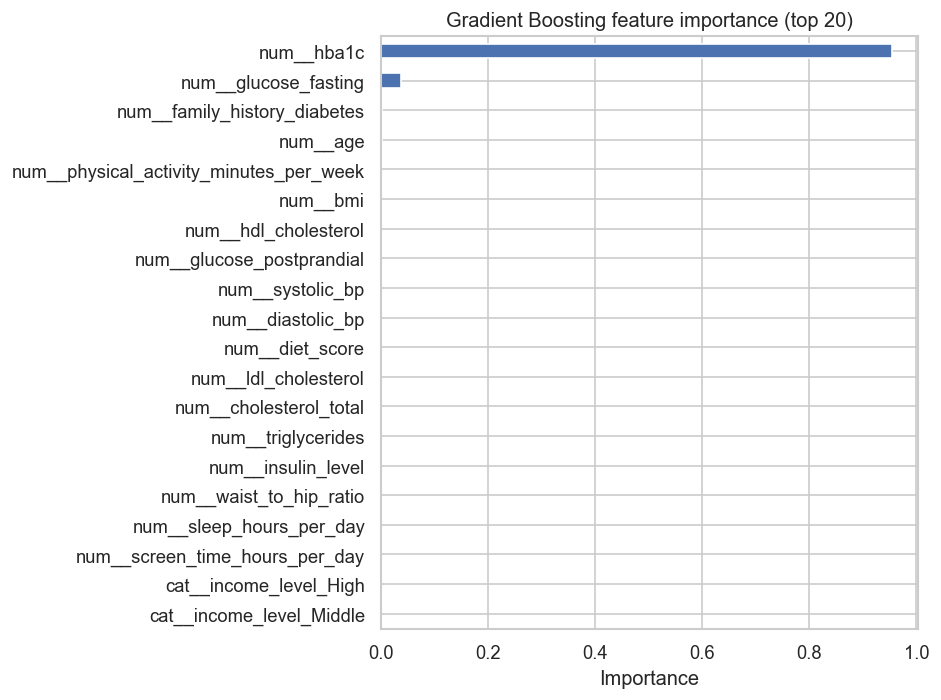

In [16]:
# ============================================================
# 9. Model interpretation: coefficients and feature importance
# ============================================================

# Helper to get feature names after preprocessing (numeric + one-hot categorical)
def get_transformed_feature_names(preprocessor):
    """
    Returns a list of feature names after ColumnTransformer
    (works for StandardScaler + OneHotEncoder).
    """
    try:
        return preprocessor.get_feature_names_out()
    except AttributeError:
        # Older sklearn fallback: build names manually
        feature_names = []

        for name, transformer, cols in preprocessor.transformers_:
            if transformer == "drop":
                continue
            if transformer == "passthrough":
                feature_names.extend(cols)
            else:
                if hasattr(transformer, "get_feature_names_out"):
                    feature_names.extend(transformer.get_feature_names_out(cols))
                else:
                    feature_names.extend(cols)
        return np.array(feature_names)


# -------- Logistic Regression coefficients --------
logreg_pre = best_log_reg.named_steps["preprocess"]
logreg_model = best_log_reg.named_steps["model"]

logreg_feature_names = get_transformed_feature_names(logreg_pre)
logreg_coefs = pd.Series(logreg_model.coef_[0], index=logreg_feature_names)

logreg_coefs_sorted = logreg_coefs.reindex(logreg_coefs.abs().sort_values(ascending=False).index)

print("\nTop 20 Logistic Regression coefficients (by absolute value):")
print(logreg_coefs_sorted.head(20))

plt.figure(figsize=(8, 6))
logreg_coefs_sorted.head(20).sort_values().plot(kind="barh")
plt.title("Top Logistic Regression coefficients (absolute value)")
plt.xlabel("Coefficient value")
plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, "logreg_top_coeffs.png"), dpi=300)
plt.show()


# -------- Random Forest feature importance --------
rf_pre = best_rf.named_steps["preprocess"]
rf_model = best_rf.named_steps["model"]

rf_feature_names = get_transformed_feature_names(rf_pre)
rf_importances = pd.Series(rf_model.feature_importances_, index=rf_feature_names).sort_values(ascending=False)

print("\nTop 20 Random Forest feature importances:")
print(rf_importances.head(20))

plt.figure(figsize=(8, 6))
rf_importances.head(20).sort_values().plot(kind="barh")
plt.title("Random Forest feature importance (top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, "rf_feature_importance.png"), dpi=300)
plt.show()


# -------- Gradient Boosting feature importance --------
gb_pre = best_gb.named_steps["preprocess"]
gb_model = best_gb.named_steps["model"]

gb_feature_names = get_transformed_feature_names(gb_pre)
gb_importances = pd.Series(gb_model.feature_importances_, index=gb_feature_names).sort_values(ascending=False)

print("\nTop 20 Gradient Boosting feature importances:")
print(gb_importances.head(20))

plt.figure(figsize=(8, 6))
gb_importances.head(20).sort_values().plot(kind="barh")
plt.title("Gradient Boosting feature importance (top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, "gb_feature_importance.png"), dpi=300)
plt.show()

In [17]:
# If SHAP is not installed yet, uncomment and run this line ONCE:
# %pip install shap

import shap

# For JS-based plots in notebooks (optional)
shap.initjs()

/opt/miniconda3/envs/cmse492/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/var/folders/bl/lvtt_0f17y9bmbx8m8m66x3c0000gn/T/ipykernel_38340/3192000013.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


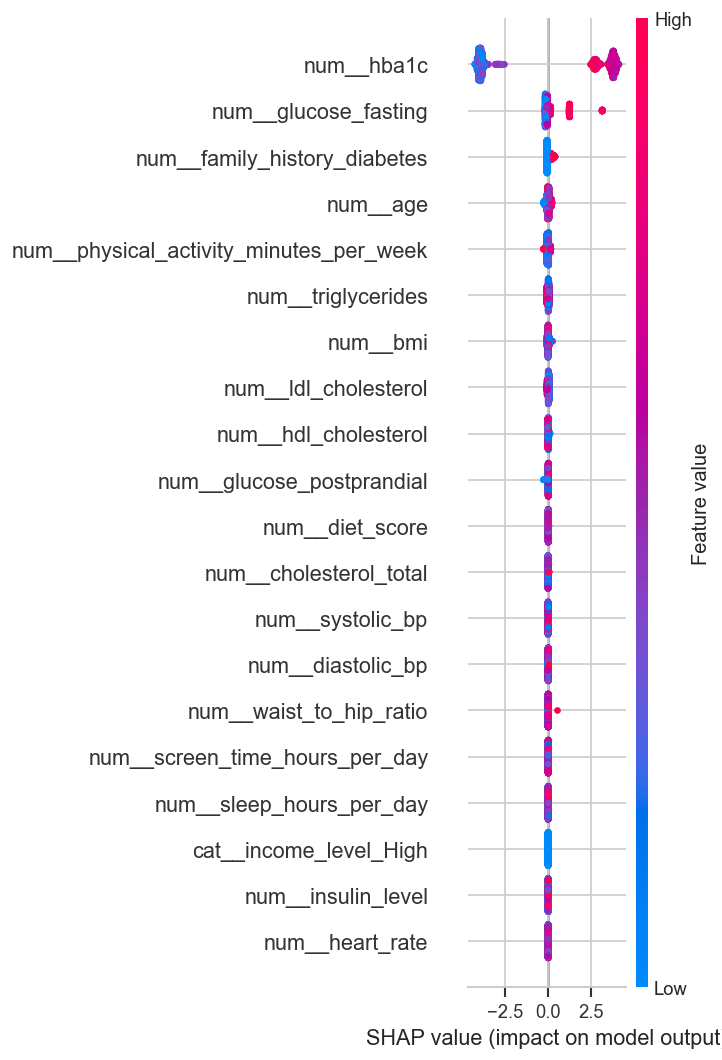

Saved: shap_summary_beeswarm_gradient_boosting.png


/var/folders/bl/lvtt_0f17y9bmbx8m8m66x3c0000gn/T/ipykernel_38340/3192000013.py:51: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


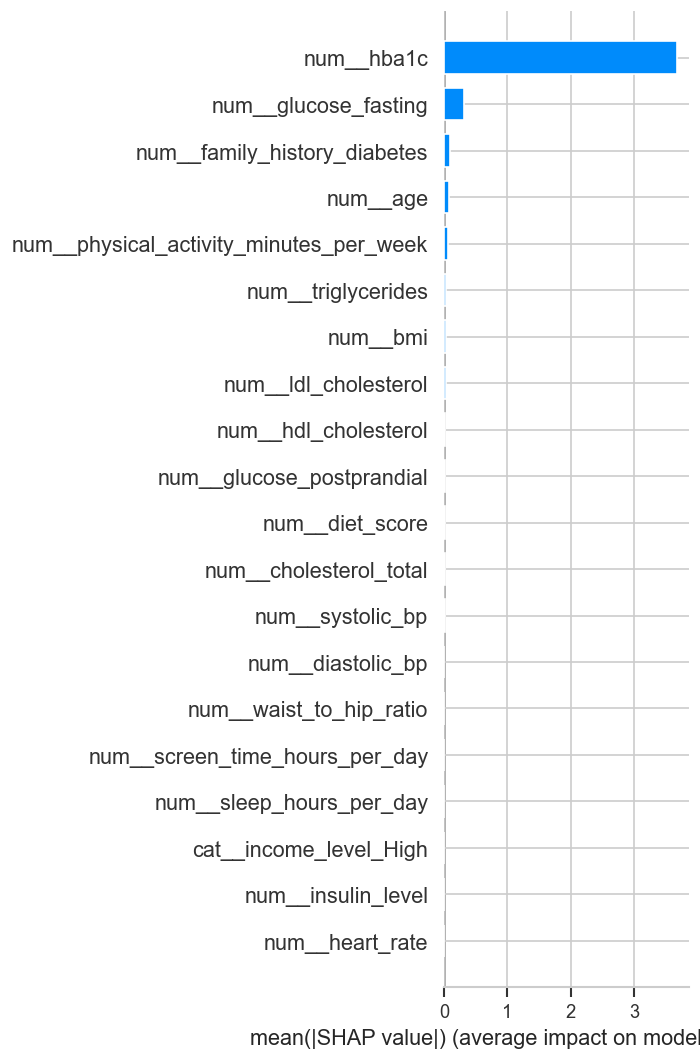

Saved: shap_feature_importance_bar_gradient_boosting.png


In [20]:
# -------------------------------------------------------
# SHAP ANALYSIS FOR GRADIENT BOOSTING (Display + Save)
# -------------------------------------------------------

import shap
shap.initjs()

# 1. Fit the SHAP explainer on the best Gradient Boosting model
gb_model = best_gb.named_steps["model"]
preprocessor_fitted = best_gb.named_steps["preprocess"]

# Subsample for speed (optional but recommended)
X_train_sample = X_train.sample(n=2000, random_state=42)

# Transform data into model input space
X_train_processed = preprocessor_fitted.transform(X_train_sample)

# TreeExplainer for Gradient Boosting
explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_train_processed)

# Get feature names after ColumnTransformer
feature_names = preprocessor_fitted.get_feature_names_out()

# -------------------------------------------------------
# 2. SHAP SUMMARY BEESWARM PLOT
# -------------------------------------------------------
shap.summary_plot(
    shap_values,
    X_train_processed,
    feature_names=feature_names,
    show=False
)

fig = plt.gcf()
fig.set_size_inches(6, 9)
fig.tight_layout()
fig.savefig(
    os.path.join(FIG_PATH, "shap_summary_beeswarm_gradient_boosting.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()
plt.close(fig)

print("Saved:", "shap_summary_beeswarm_gradient_boosting.png")

# -------------------------------------------------------
# 3. SHAP BAR PLOT (MEAN |SHAP|)
# -------------------------------------------------------
shap.summary_plot(
    shap_values,
    X_train_processed,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)

fig = plt.gcf()
fig.set_size_inches(6, 9)
fig.tight_layout()
fig.savefig(
    os.path.join(FIG_PATH, "shap_feature_importance_bar_gradient_boosting.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()
plt.close(fig)

print("Saved:", "shap_feature_importance_bar_gradient_boosting.png")